In [1]:
import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm as tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from fbprophet import Prophet
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('sdwpf134_initial_kddcup.csv')

In [12]:
data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,time_day
0,1,1,00:00,2.81,-2.00,16.61,30.95,148.0,0.03,0.03,0.03,-19.38,111.13,0
1,1,1,00:15,2.48,-4.30,16.38,30.83,148.0,0.03,0.03,0.03,-15.69,75.30,15
2,1,1,00:30,1.16,9.28,16.62,31.05,135.0,0.03,0.03,0.03,-2.50,9.54,30
3,1,1,00:45,0.92,14.38,16.13,31.20,148.0,0.04,0.04,0.03,-0.70,0.00,45
4,1,1,01:00,1.38,-4.28,15.12,29.52,148.0,89.68,89.69,89.50,-0.30,0.00,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90043,134,7,22:45,9.94,1.90,22.75,22.63,181.0,90.40,90.39,90.00,-0.30,0.00,1365
90044,134,7,23:00,9.94,1.90,22.75,22.63,181.0,90.40,90.39,90.00,-0.30,0.00,1380
90045,134,7,23:15,9.94,1.90,22.75,22.63,181.0,90.40,90.39,90.00,-0.30,0.00,1395
90046,134,7,23:30,9.94,1.90,22.75,22.63,181.0,90.40,90.39,90.00,-0.30,0.00,1410


In [4]:
type(data['Day'][0])

numpy.int64

In [5]:
type(data['Tmstamp'][0])

str

In [6]:
data['TurbID'].nunique()

134

In [7]:
data['Day'].nunique()

7

In [8]:
timelength = data['Tmstamp'].nunique()*data['Day'].nunique()
print(timelength)

672


In [9]:
# 获取一周的时间index 1-672
def get_time_week(data):
    tmp = []
    timelength = data['Tmstamp'].nunique()*data['Day'].nunique()
    for i in range(data['TurbID'].nunique()):
        tmp  = tmp + list(range(timelength))
    data['time_week'] = tmp

In [10]:
# 获取一天的时间index 0，15，30...

def get_time_day(data):
    tmp = []
    timelength = data['Tmstamp'].nunique()*data['Day'].nunique()
    tmstamp = data['Tmstamp'][:timelength].tolist()
    tmstamp_num = []
    for i in tmstamp:
        tmstamp_num.append(int(i[:2])*60+int(i[3:]))
    for i in range(data['TurbID'].nunique()):
        tmp  = tmp + tmstamp_num
    data['time_day'] = tmp

In [11]:
get_time_day(data)

In [601]:
data_patv = data.Patv
data = data.drop('Patv',axis=1)
data.insert(0,'Patv',data_patv)

In [506]:
# 对角度做三角函数
data['Ndir'] = np.sin(data['Ndir'])
data['Pab1'] = np.sin(data['Pab1'])
data['Pab2'] = np.sin(data['Pab2'])
data['Pab3'] = np.sin(data['Pab3'])

In [602]:
# 时间的三角函数处理，与归一化选一个使用

def time_triangle(data):
    time = []
    for i in range(len(data.Tmstamp)):
        time.append(datetime.datetime.strptime(data.Tmstamp[i],'%M:%S'))
    data['timestamp'] = time
    timestamp_s = data['timestamp'].map(datetime.datetime.timestamp)
    day = 24*60*60
    data['Day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    data['Day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))

0   1900-01-01 00:00:00
1   1900-01-01 00:00:15
2   1900-01-01 00:00:30
3   1900-01-01 00:00:45
4   1900-01-01 00:01:00
Name: timestamp, dtype: datetime64[ns]

In [471]:
# 归一化
def normalization(data):
    scaler = lambda x : (x-np.min(x)) / (np.max(x)-np.min(x))
    
    # (-1,1)
    # scaler = MinMaxScaler(feature_range=(0, 1))
    # scaler_a1 = MinMaxScaler(feature_range=(0, 1)).fit(pf[["attribute1"]])
    data = pd.DataFrame(scaler.fit_transform(data),
                                 columns = data.columns.values,
                                index = data.index)
    # data.time_week = data[['time_week']].apply(scaler)
    # data.time_day = data[['time_day']].apply(scaler)

In [568]:
# 异常值处理-外部温度

def Etmp_anomaly_process(data):
    normal_etmp = data[(data["Etmp"] >= -50) & (data["Etmp"] <= 50)]["Etmp"]

    # 定义3σ原则表达式
    min_mask = data["Etmp"] < (normal_etmp.mean() - 3 * normal_etmp.std())
    max_mask = data["Etmp"] > (normal_etmp.mean() + 3 * normal_etmp.std())

    # 只要满足上诉表达式的任一个就为异常值，所以这里使用位与运算
    mask = min_mask | max_mask

    data.loc[mask,"Etmp"] = normal_etmp.mean()

In [ ]:
# 异常值处理-内部温度

def Itmp_anomaly_process(data):
    normal_itmp = data[(data["Itmp"] > 0) & (data["Itmp"] <= 50)]["Itmp"]

    # 定义3σ原则表达式
    min_mask = data["Itmp"] < (normal_itmp.mean() - 3 * normal_itmp.std())
    max_mask = data["Itmp"] > (normal_itmp.mean() + 3 * normal_itmp.std())

    # 只要满足上诉表达式的任一个就为异常值，所以这里使用位与运算
    mask = min_mask | max_mask

    data.loc[mask,"Itmp"] = normal_itmp.mean()

In [585]:
# 去除不需要的列

data = data.drop('Tmstamp',axis=1)

KeyError: "['Tmstamp'] not found in axis"

In [587]:
# 划分数据集

def dataset_split(data):
    train_data = data.loc[data['Day'] != 7]
    test_data = data.loc[data['Day'] == 7]

    train_feat = train_data.drop('Patv',axis=1)
    train_label = train_data['Patv']
    test_feat = test_data.drop('Patv',axis=1)
    test_label = test_data['Patv']
    
    return train_feat, train_label, test_feat, test_label

12864


In [440]:
# 网格搜索，参数优化
estimator = LGBMRegressor(num_leaves=31)
param_grid = {
    'learning_rate': [0.1, 0.3, 0.5, 0.7, 1],
    'n_estimators': [80, 100, 120, 140, 160],
    'max_depth':[6,7,8],
    'num_leaves':[68,74,80,86,92]
}
gridsearch = GridSearchCV(estimator, param_grid)
gridsearch.fit(train_feat, train_label)
print('Best parameters found by grid search are:', gridsearch.best_params_)
gbm = gridsearch.best_estimator_

Best parameters found by grid search are: {'learning_rate': 0.3, 'n_estimators': 160}


In [588]:
gbm = LGBMRegressor(max_depth=7, num_leaves=80, learning_rate=0.1)
gbm.fit(train_feat, train_label)

LGBMRegressor(max_depth=7, num_leaves=80)

In [589]:
y_pred = gbm.predict(test_feat, num_iteration=gbm.best_iteration_)

for i in range(len(y_pred)):
    if y_pred[i] < 0:
        y_pred[i] = 0

# 模型评估
print('The rmse of prediction is:', mean_squared_error(test_label, y_pred) ** 0.5)

# 模型评估
print('The mse of prediction is:', mean_squared_error(test_label, y_pred))

# 特征重要度
print('{}\nFeature importances:{}'.format([column for column in train_feat], list(gbm.feature_importances_)))

The rmse of prediction is: 77.61447512679827
The mse of prediction is: 6024.006749208386
['TurbID', 'Day', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv']
Feature importances:[986, 470, 1350, 437, 706, 429, 566, 598, 260, 340, 1485]


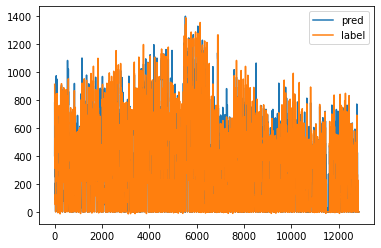

In [590]:
plt.plot(range(len(y_pred)), y_pred,label='pred')
plt.plot(range(len(test_label)), test_label, label='label')
plt.legend()

# Prophet

In [437]:
prophet = Prophet()
prophet.fit(train_data)

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [ ]:
y_pred = prophet.predict(test_data)

for i in range(len(y_pred)):
    if y_pred[i] < 0:
        y_pred[i] = 0

# 模型评估
print('The rmse of prediction is:', mean_squared_error(test_label, y_pred) ** 0.5)

# 模型评估
print('The mse of prediction is:', mean_squared_error(test_label, y_pred))

# ARIMA

In [438]:
#1,1,2模型检验
model = ARIMA(data,order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

ValueError: endog is required to have ndim 1 but has ndim 2

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf

# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train_data, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
data = pd.read_csv('sdwpf134_initial_kddcup.csv')

In [ ]:
# 聚类分析
# k-means 聚类
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from matplotlib import pyplot

# 定义模型
model = KMeans(n_clusters=2)
# 模型拟合
model.fit(data)
# 为每个示例分配一个集群
yhat = model.predict(data)
# 检索唯一群集
clusters = unique(yhat)

# 为每个群集的样本创建散点图
for cluster in clusters:
    row_ix = where(yhat == cluster)
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
pyplot.show()

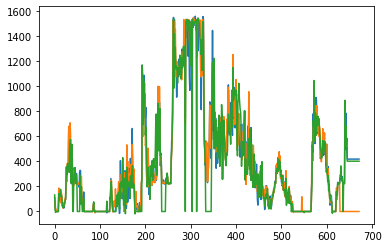

In [229]:
# 画出n台机器的某列数据

# pandas数据，某列的名称（字符串），包含了TurbID的数组
def plot_patv(data, column, li):
    TurbIDs = sorted(list(set(data['TurbID'])))
    d_cols = [column]
    for i in range(len(li)):
        patv = data.loc[data['TurbID'] == TurbIDs[li[i]]].set_index('TurbID')[d_cols]
        patv = patv.T.values[0]
        plt.plot(range(len(patv)), patv)
        
# fig = make_subplots(rows=3, cols=1)

# fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=False,
#                     mode='lines', name="First sample",
#                          marker=dict(color="mediumseagreen")),
#              row=1, col=1)

# fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=False,
#                     mode='lines', name="Second sample",
#                          marker=dict(color="violet")),
#              row=2, col=1)

# fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=False,
#                     mode='lines', name="Third sample",
#                          marker=dict(color="dodgerblue")),
#              row=3, col=1)

# fig.update_layout(height=1200, width=800, title_text="Sample sales")
# fig.show()

In [231]:
avg_mse = 0
for i in range(len(TurbIDs)):
    if i == 0:
        continue
    avg_mse += mean_squared_error(patv_1, data.loc[data['TurbID'] == TurbIDs[i]].set_index('TurbID')[d_cols])
avg_mse /= (len(TurbIDs)-1)
print('和第一台机器的patv做mse，得到的均值：',avg_mse)

和第一台机器的patv做mse，得到的均值： 45691.35750309815


In [232]:
l_sim = []
l_unsim = []
max_mse = 0
max_mse_id = 0
for i in range(len(TurbIDs)):
    if i == 0:
        continue
    tmp_mse = mean_squared_error(patv_1, data.loc[data['TurbID'] == TurbIDs[i]].set_index('TurbID')[d_cols])
    if max_mse < tmp_mse:
        max_mse = tmp_mse
        max_mse_id = i
    if tmp_mse < avg_mse:
        l_sim.append(i)
    else:
        l_unsim.append(i)
print('与第一台机器的patv相似的机器：',len(l_sim))
print('max_mse:',max_mse)
print('max_mse_id:',max_mse_id)

与第一台机器的patv相似的机器： 99
max_mse: 292783.857778125
max_mse_id: 120


In [244]:
print('l_sim',l_sim)
print('l_unsim',l_unsim)

l_sim [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 30, 31, 32, 33, 34, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 56, 63, 65, 67, 68, 69, 70, 72, 73, 74, 75, 77, 78, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 101, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 121, 122, 123, 126, 127, 129, 130, 131, 132, 133]
l_unsim [12, 14, 27, 29, 35, 36, 37, 38, 39, 44, 54, 55, 57, 58, 59, 60, 61, 62, 64, 66, 71, 76, 79, 80, 81, 99, 100, 102, 108, 118, 120, 124, 125, 128]


In [234]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per')

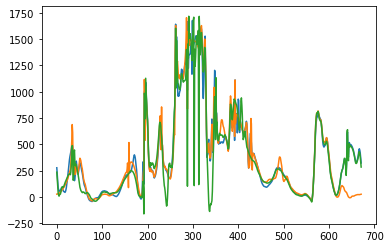

In [235]:
y_w1 = denoise_signal(patv_1)
y_w2 = denoise_signal(patv_2)
y_w3 = denoise_signal(patv_3)

plt.plot(range(len(y_w1)), y_w1)
plt.plot(range(len(y_w2)), y_w2)
plt.plot(range(len(y_w3)), y_w3)

# fig = make_subplots(rows=3, cols=1)

# fig.add_trace(
#     go.Scatter(x=np.arange(len(x_1)), mode='lines+markers', y=x_1, marker=dict(color="mediumaquamarine"), showlegend=False,
#                name="Original signal"),
#     row=1, col=1
# )

# fig.add_trace(
#     go.Scatter(x=np.arange(len(x_1)), y=y_w1, mode='lines', marker=dict(color="darkgreen"), showlegend=False,
#                name="Denoised signal"),
#     row=1, col=1
# )

# fig.add_trace(
#     go.Scatter(x=np.arange(len(x_2)), mode='lines+markers', y=x_2, marker=dict(color="thistle"), showlegend=False),
#     row=2, col=1
# )

# fig.add_trace(
#     go.Scatter(x=np.arange(len(x_2)), y=y_w2, mode='lines', marker=dict(color="purple"), showlegend=False),
#     row=2, col=1
# )

# fig.add_trace(
#     go.Scatter(x=np.arange(len(x_3)), mode='lines+markers', y=x_3, marker=dict(color="lightskyblue"), showlegend=False),
#     row=3, col=1
# )

# fig.add_trace(
#     go.Scatter(x=np.arange(len(x_3)), y=y_w3, mode='lines', marker=dict(color="navy"), showlegend=False),
#     row=3, col=1
# )

# fig.update_layout(height=1200, width=800, title_text="Original (pale) vs. Denoised (dark) sales")
# fig.show()

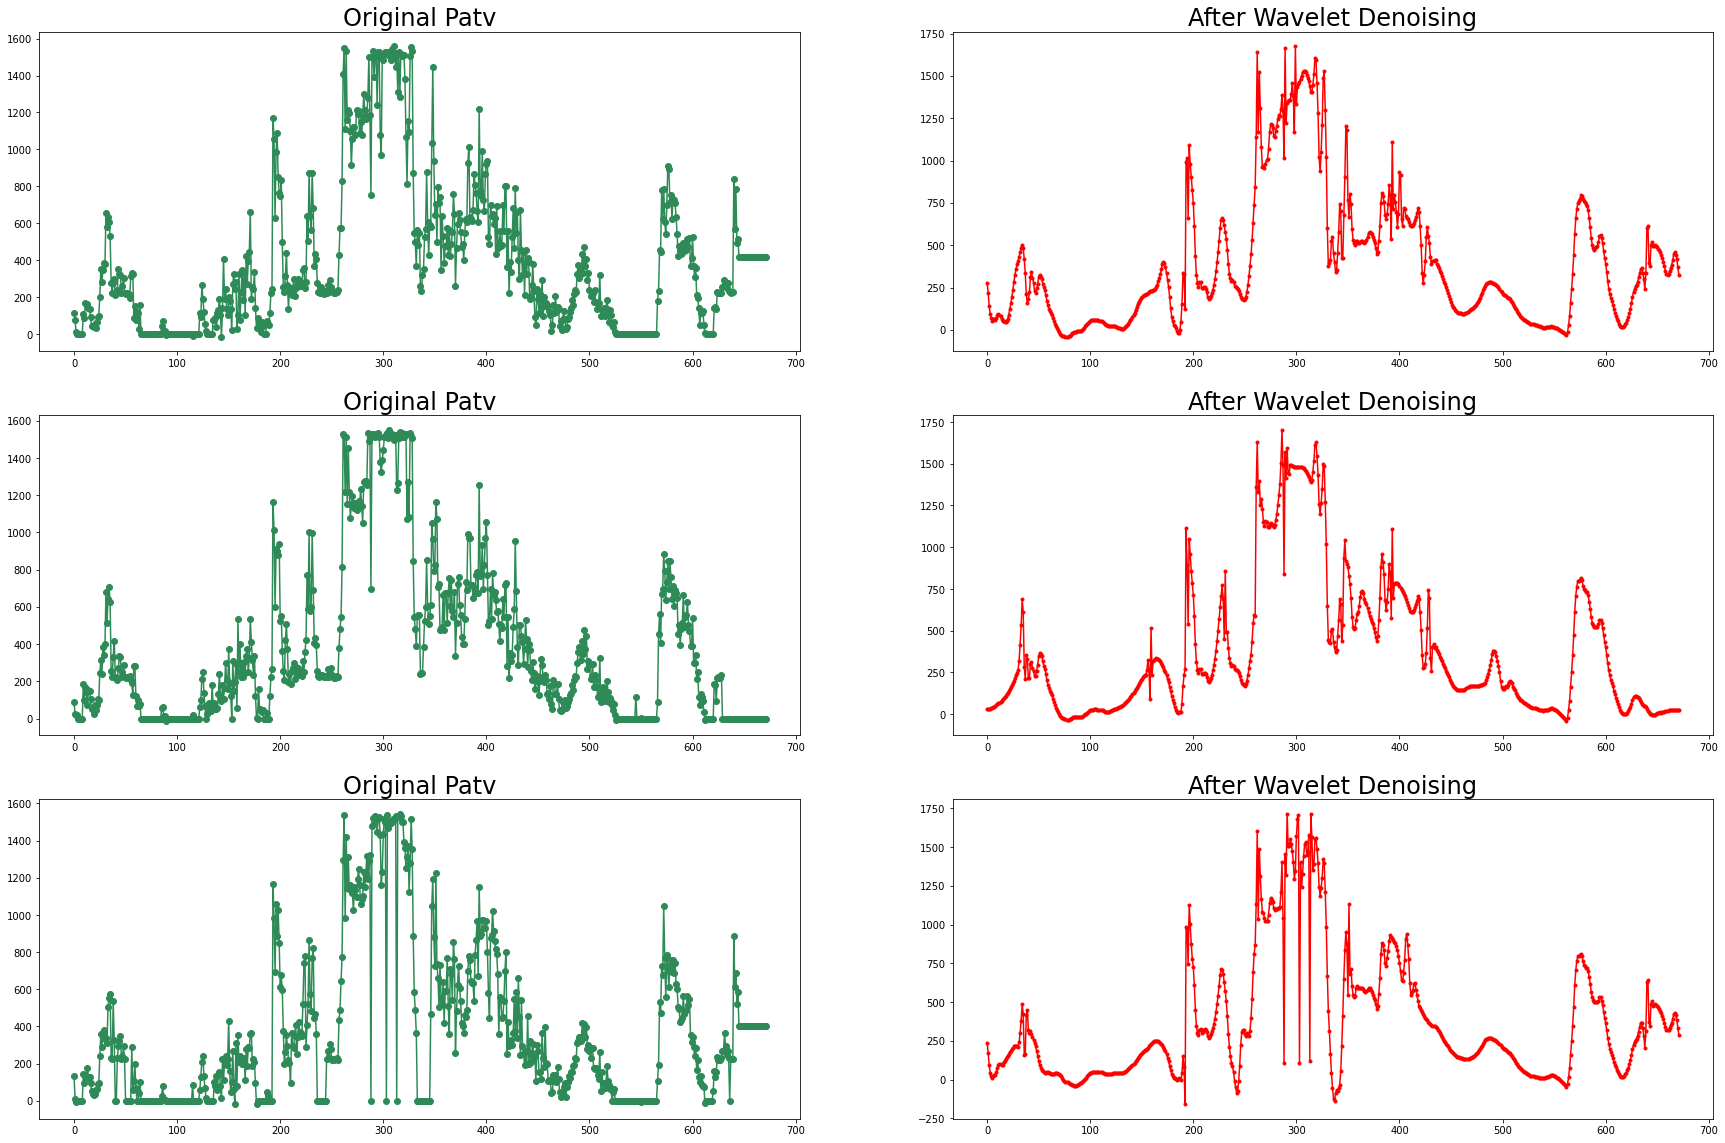

In [236]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(30, 20))

ax[0, 0].plot(patv_1, color='seagreen', marker='o') 
ax[0, 0].set_title('Original Patv', fontsize=24)
ax[0, 1].plot(y_w1, color='red', marker='.') 
ax[0, 1].set_title('After Wavelet Denoising', fontsize=24)

ax[1, 0].plot(patv_2, color='seagreen', marker='o') 
ax[1, 0].set_title('Original Patv', fontsize=24)
ax[1, 1].plot(y_w2, color='red', marker='.') 
ax[1, 1].set_title('After Wavelet Denoising', fontsize=24)

ax[2, 0].plot(patv_3, color='seagreen', marker='o') 
ax[2, 0].set_title('Original Patv', fontsize=24)
ax[2, 1].plot(y_w3, color='red', marker='.') 
ax[2, 1].set_title('After Wavelet Denoising', fontsize=24)

plt.show()

In [237]:
def average_smoothing(signal, kernel_size=3, stride=1):
    sample = []
    start = 0
    end = kernel_size
    while end <= len(signal):
        start = start + stride
        end = end + stride
        sample.extend(np.ones(end - start)*np.mean(signal[start:end]))
    return np.array(sample)

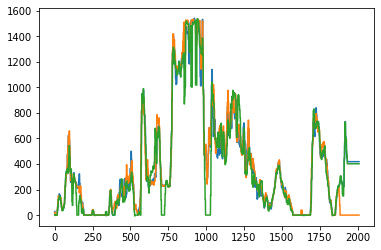

In [238]:
y_a1 = average_smoothing(patv_1)
y_a2 = average_smoothing(patv_2)
y_a3 = average_smoothing(patv_3)

plt.plot(range(len(y_a1)), y_a1)
plt.plot(range(len(y_a2)), y_a2)
plt.plot(range(len(y_a3)), y_a3)

# fig = make_subplots(rows=3, cols=1)

# fig.add_trace(
#     go.Scatter(x=np.arange(len(x_1)), mode='lines+markers', y=x_1, marker=dict(color="lightskyblue"), showlegend=False,
#                name="Original sales"),
#     row=1, col=1
# )

# fig.add_trace(
#     go.Scatter(x=np.arange(len(x_1)), y=y_a1, mode='lines', marker=dict(color="navy"), showlegend=False,
#                name="Denoised sales"),
#     row=1, col=1
# )

# fig.add_trace(
#     go.Scatter(x=np.arange(len(x_2)), mode='lines+markers', y=x_2, marker=dict(color="thistle"), showlegend=False),
#     row=2, col=1
# )

# fig.add_trace(
#     go.Scatter(x=np.arange(len(x_2)), y=y_a2, mode='lines', marker=dict(color="indigo"), showlegend=False),
#     row=2, col=1
# )

# fig.add_trace(
#     go.Scatter(x=np.arange(len(x_3)), mode='lines+markers', y=x_3, marker=dict(color="mediumaquamarine"), showlegend=False),
#     row=3, col=1
# )

# fig.add_trace(
#     go.Scatter(x=np.arange(len(x_3)), y=y_a3, mode='lines', marker=dict(color="darkgreen"), showlegend=False),
#     row=3, col=1
# )

# fig.update_layout(height=1200, width=800, title_text="Original (pale) vs. Denoised (dark) signals")
# fig.show()

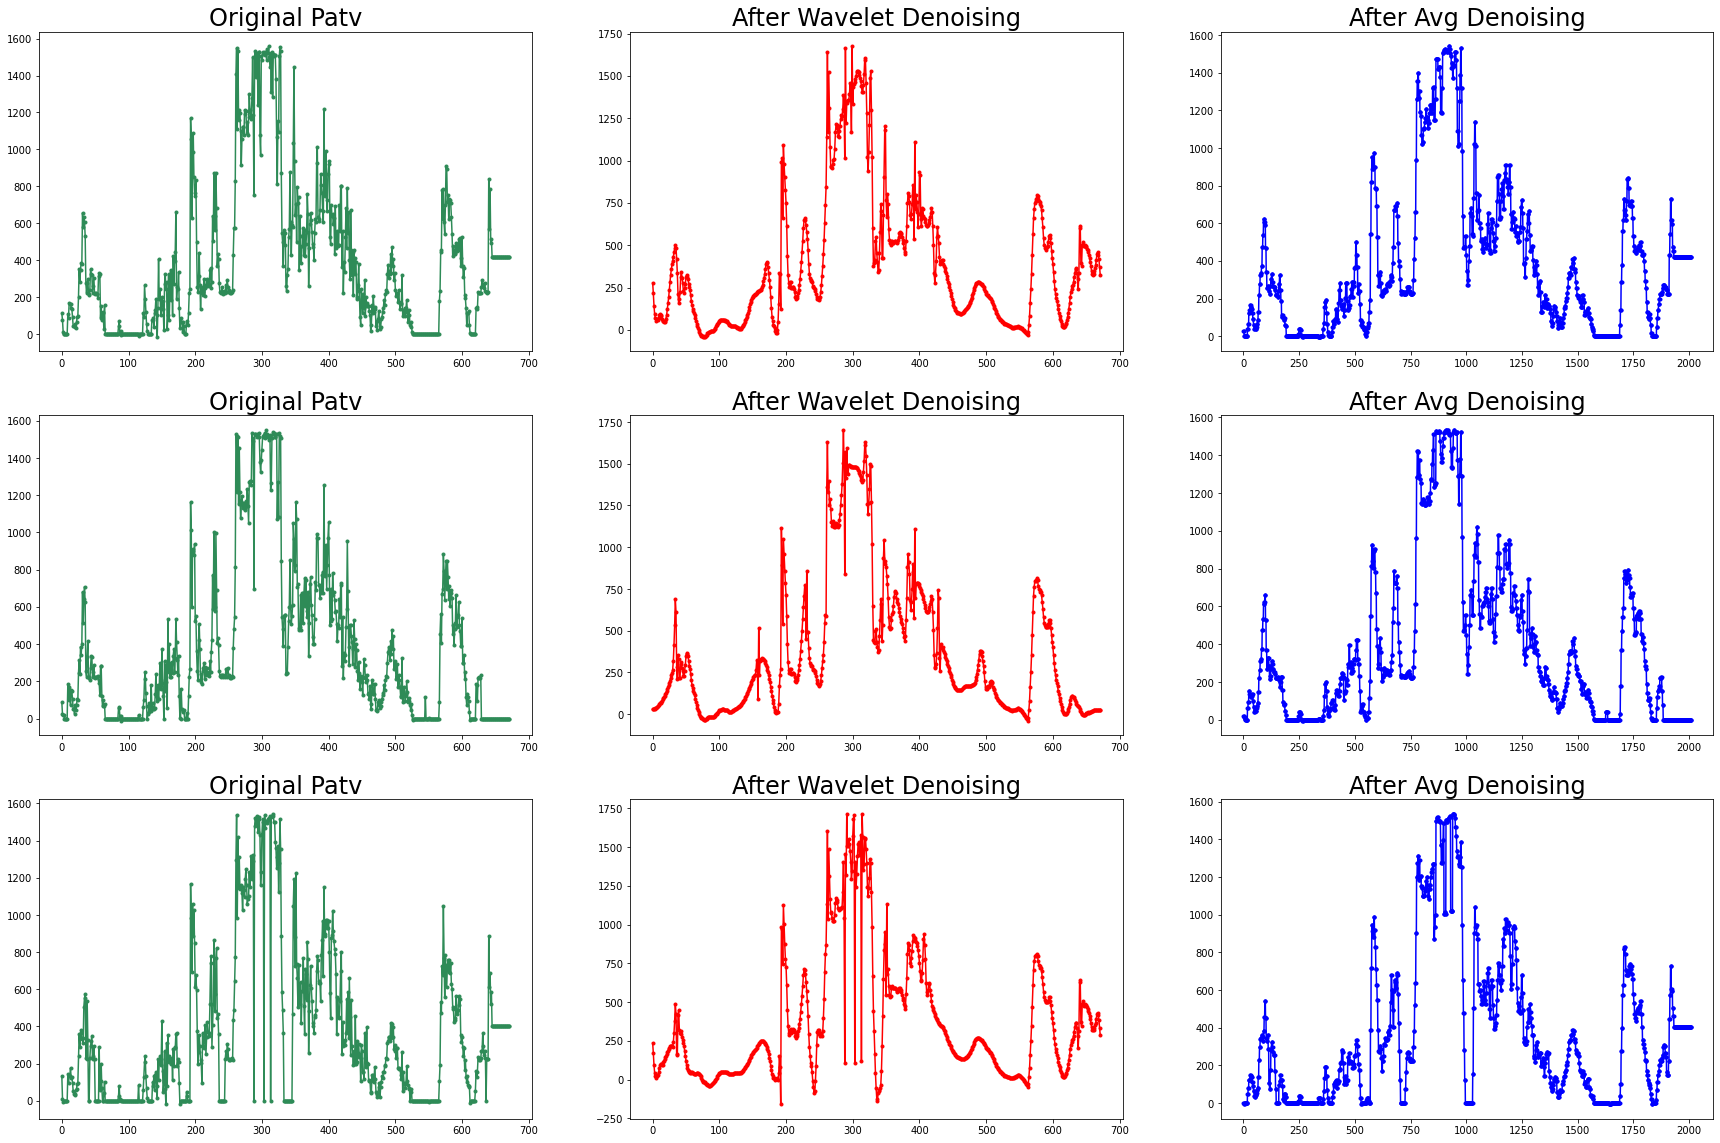

In [240]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(30, 20))

ax[0, 0].plot(patv_1, color='seagreen', marker='.') 
ax[0, 0].set_title('Original Patv', fontsize=24)
ax[0, 1].plot(y_w1, color='red', marker='.') 
ax[0, 1].set_title('After Wavelet Denoising', fontsize=24)
ax[0, 2].plot(y_a1, color='blue', marker='.') 
ax[0, 2].set_title('After Avg Denoising', fontsize=24)

ax[1, 0].plot(patv_2, color='seagreen', marker='.') 
ax[1, 0].set_title('Original Patv', fontsize=24)
ax[1, 1].plot(y_w2, color='red', marker='.') 
ax[1, 1].set_title('After Wavelet Denoising', fontsize=24)
ax[1, 2].plot(y_a2, color='blue', marker='.') 
ax[1, 2].set_title('After Avg Denoising', fontsize=24)

ax[2, 0].plot(patv_3, color='seagreen', marker='.') 
ax[2, 0].set_title('Original Patv', fontsize=24)
ax[2, 1].plot(y_w3, color='red', marker='.') 
ax[2, 1].set_title('After Wavelet Denoising', fontsize=24)
ax[2, 2].plot(y_a3, color='blue', marker='.') 
ax[2, 2].set_title('After Avg Denoising', fontsize=24)

plt.show()

In [104]:
data.set_index('TurbID')[['Tmstamp']].head()

,Tmstamp
TurbID,
1,00:00
1,00:15
1,00:30
1,00:45
1,01:00


In [105]:
data.set_index('TurbID')[d_cols].head()

,Patv
TurbID,
1,111.13
1,75.30
1,9.54
1,0.00
1,0.00


In [113]:
data.set_index('TurbID')[['time']][670:675]

,time
TurbID,
1,670
1,671
2,0
2,1
2,2


In [114]:
data['time']

0          0
1          1
2          2
3          3
4          4
        ... 
90043    667
90044    668
90045    669
90046    670
90047    671
Name: time, Length: 90048, dtype: int64

In [134]:
past_patv = data.set_index('TurbID')[d_cols]
past_patv['time'] = tmp
# past_patv = past_patv.T
print(past_patv)

          Patv  time
TurbID              
1       111.13     0
1        75.30     1
1         9.54     2
1         0.00     3
1         0.00     4
...        ...   ...
134       0.00   667
134       0.00   668
134       0.00   669
134       0.00   670
134       0.00   671

[90048 rows x 2 columns]


In [137]:
turb_list = data['TurbID'].unique()
for t in turb_list:
    a = data.loc[timelength*(t-1):timelength*t-1,['Patv']]

       Patv
0    111.13
1     75.30
2      9.54
3      0.00
4      0.00
..      ...
667  418.32
668  418.32
669  418.32
670  418.32
671  418.32

[672 rows x 1 columns]
       Patv
672   86.46
673   22.74
674   20.53
675   18.28
676    0.00
...     ...
1339   0.00
1340   0.00
1341   0.00
1342   0.00
1343   0.00

[672 rows x 1 columns]
        Patv
1344  132.07
1345   10.90
1346   -7.28
1347    0.00
1348    0.00
...      ...
2011  401.65
2012  401.65
2013  401.65
2014  401.65
2015  401.65

[672 rows x 1 columns]
        Patv
2016   42.04
2017   52.12
2018   -4.69
2019    0.00
2020    0.00
...      ...
2683  390.33
2684  390.33
2685  390.33
2686  390.33
2687  390.33

[672 rows x 1 columns]
        Patv
2688   85.00
2689   62.83
2690   29.54
2691   51.58
2692    0.00
...      ...
3355  381.43
3356  381.43
3357  381.43
3358  381.43
3359  381.43

[672 rows x 1 columns]
        Patv
3360   52.68
3361   48.51
3362   28.59
3363    0.00
3364    0.00
...      ...
4027  405.41
4028  405.41
4029  4

[672 rows x 1 columns]
       Patv
44352   0.0
44353   0.0
44354   0.0
44355   0.0
44356   0.0
...     ...
45019   0.0
45020   0.0
45021   0.0
45022   0.0
45023   0.0

[672 rows x 1 columns]
        Patv
45024  91.56
45025  56.53
45026   0.00
45027   0.00
45028   0.00
...      ...
45691   0.00
45692   0.00
45693   0.00
45694   0.00
45695   0.00

[672 rows x 1 columns]
        Patv
45696  49.99
45697  64.48
45698  30.70
45699   0.00
45700   0.00
...      ...
46363   0.00
46364   0.00
46365   0.00
46366   0.00
46367   0.00

[672 rows x 1 columns]
         Patv
46368  144.98
46369  212.66
46370   63.50
46371   27.00
46372    0.00
...       ...
47035  379.32
47036  379.32
47037  379.32
47038  379.32
47039  379.32

[672 rows x 1 columns]
        Patv
47040  42.96
47041  80.76
47042  30.11
47043   0.00
47044   0.00
...      ...
47707   0.00
47708   0.00
47709   0.00
47710   0.00
47711   0.00

[672 rows x 1 columns]
          Patv
47712   235.86
47713   190.86
47714   109.10
47715    47.55
47